In [1]:
!pip install roboflow --quiet
!pip install ultralytics --quiet
import ultralytics
print(ultralytics.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 22.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
8.3.23


In [2]:
# Se descarga el dataset anotado

from roboflow import Roboflow
rf = Roboflow(api_key="pEW4ejQrgMuyXc6bqcmR")
project = rf.workspace("sebastian-5vpki").project("avance5")
version = project.version(1)
dataset = version.download("yolokeras")

path = '/content/Avance5-1'

# Descarga modelo entrenado
!wget https://jsob.blob.core.windows.net/personal/best.pt


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Avance5-1 in yolokeras:: 100%|██████████| 658/658 [00:00<00:00, 1714.25it/s]


--2024-10-28 01:52:39--  https://jsob.blob.core.windows.net/personal/best.pt
Resolving jsob.blob.core.windows.net (jsob.blob.core.windows.net)... 20.209.179.65
Connecting to jsob.blob.core.windows.net (jsob.blob.core.windows.net)|20.209.179.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22523683 (21M) [application/octet-stream]
Saving to: ‘best.pt’

best.pt             100%[===================>]  21.48M  7.21MB/s    in 3.0s    

2024-10-28 01:52:42 (7.21 MB/s) - ‘best.pt’ saved [22523683/22523683]



In [3]:
path = '/content/Avance5-1'
conf = 0.5
modelos = []
AUC_ROC= []
AUC_Precisión_Recall= []
f1_score = []
predicciones1 = []
predicciones2 = []
predicciones3 = []
reales = []



In [4]:
from ultralytics import YOLO
from ultralytics import RTDETR
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import numpy as np
import seaborn as sns

100%|██████████| 63.4M/63.4M [00:01<00:00, 57.6MB/s]



Estadísticas en el conjunto completo de datos para el modelo rtdetr-l.pt:
AUC ROC: 0.9890
AUC Precisión-Recall: 0.9960

Precisión promedio: 0.9928
Recall promedio: 0.5197
F1 promedio: 0.6822
[[ 32   4]
 [  0 101]]


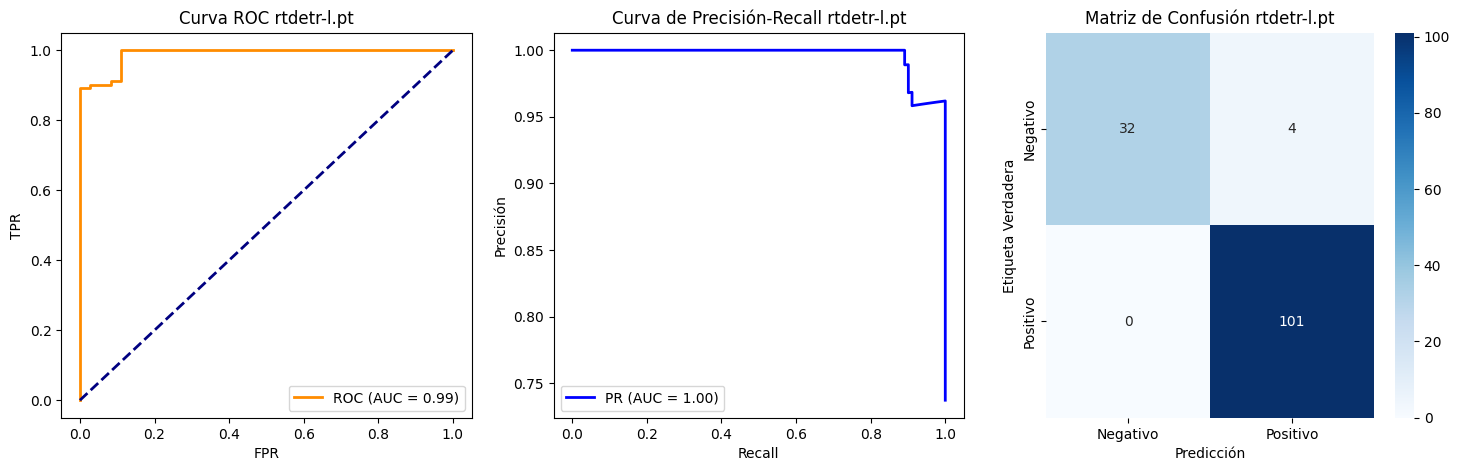

In [5]:
import matplotlib.image as mpimg

# Cargar el modelo YOLO   soportados:  yolov5nu.pt, yolov10n.pt, yolo11n.pt, yolov8s.pt, yolov8n.pt,  etc cualquiera soportado por ultralytics
modelo = 'rtdetr-l.pt'
#modelo = '/content/besttrain3.pt'
model = RTDETR(modelo)
#model = YOLO(modelo)


def detect_vehicles(image_path):
    try:
        results = model.predict(source=image_path, conf=conf, verbose=False)  # Ejecutar inferencia
        confidences = []
        for r in results:
            for box in r.boxes:
                clase = r.names[int(box.cls)]
                #print(clase)
                if clase.lower() == 'car' or clase.lower() == 'carro':
                    confidences.append(float(box.conf))  # Obtener la confianza
        return confidences
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")
        return []

# Ruta del archivo de anotaciones
file_path = f'{path}/test/_annotations.txt'

def procesar_anotaciones(file_path, umbral_min_conf=0.0):
    y_true = []
    y_scores = []

    with open(file_path, 'r') as file:
        for line in file:
            # Obtener datos de la línea
            partes = line.strip().split()
            imagen = partes[0]
            imagen_path = f'{path}/test/' + imagen
            numero_de_carros_reales = len(partes[1:])
            carros_confidencias = detect_vehicles(imagen_path)
            numero_de_carros_detectados = len(carros_confidencias)
            reales.append(numero_de_carros_reales)
            predicciones1.append(numero_de_carros_detectados)

            '''print(f"Imagen: {imagen}")
            print(f"Número de carros reales: {numero_de_carros_reales}")
            print(f"Número de carros detectados: {numero_de_carros_detectados}")


            img = mpimg.imread(imagen_path)
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes para una mejor visualización
            plt.show() '''

            # Clasificación de casos específicos
            for conf in carros_confidencias:
                y_true.append(1 if numero_de_carros_reales > 0 else 0)  # Etiqueta real
                y_scores.append(conf)  # Confianza de la predicción

            # Agregar falsos negativos y falsos positivos
            if numero_de_carros_reales > numero_de_carros_detectados:
                y_true.extend([1] * (numero_de_carros_reales - numero_de_carros_detectados))  # Falsos negativos
                y_scores.extend([0.0] * (numero_de_carros_reales - numero_de_carros_detectados))

            elif numero_de_carros_detectados > numero_de_carros_reales:
                y_true.extend([0] * (numero_de_carros_detectados - numero_de_carros_reales))  # Falsos positivos
                y_scores.extend([0.0] * (numero_de_carros_detectados - numero_de_carros_reales))

    # Calcular métricas nuevamente
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Calcular la Matriz de Confusión
    umbral = 0.5
    y_pred = (np.array(y_scores) >= umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEstadísticas en el conjunto completo de datos para el modelo {modelo}:")
    print(f"AUC ROC: {roc_auc:.4f}")
    print(f"AUC Precisión-Recall: {pr_auc:.4f}")

    # Métricas adicionales
    precision_val = precision.mean() if len(precision) > 0 else 0
    recall_val = recall.mean() if len(recall) > 0 else 0
    print(f"\nPrecisión promedio: {precision_val:.4f}")
    print(f"Recall promedio: {recall_val:.4f}")
    f1=2 * (precision_val * recall_val) / (precision_val + recall_val)
    print(f"F1 promedio: {f1:.4f}")

    #Guarda resultados para comparar
    modelos.append(modelo)
    AUC_ROC.append(precision_val)
    AUC_Precisión_Recall.append(recall_val)

    f1_score.append(f1)

    print(cm)

    plt.figure(figsize=(18, 5))

    # Curva ROC
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC {modelo}')
    plt.legend(loc="lower right")

    # Curva de Precisión-Recall
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title(f'Curva de Precisión-Recall {modelo}')
    plt.legend(loc="lower left")

    # Matriz de Confusión
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión {modelo}')

    plt.show()





# Ejecución
procesar_anotaciones(file_path)


100%|██████████| 21.5M/21.5M [00:00<00:00, 213MB/s]



Estadísticas en el conjunto completo de datos para el modelo yolov8s.pt:
AUC ROC: 0.7942
AUC Precisión-Recall: 0.9797

Precisión promedio: 0.9927
Recall promedio: 0.3816
F1 promedio: 0.5513
[[ 5  2]
 [21 55]]


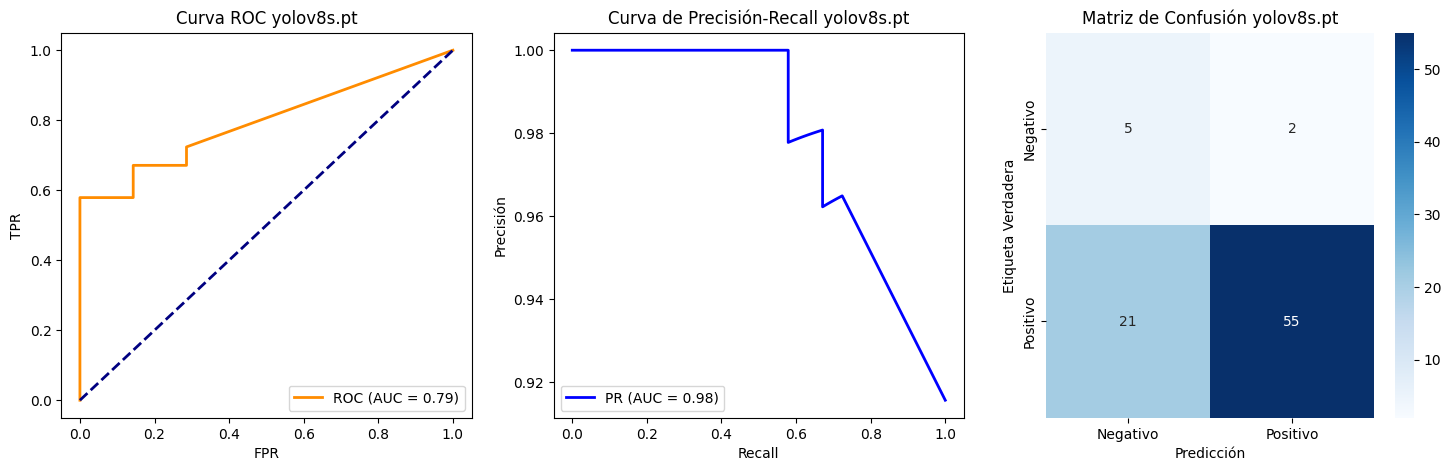

In [6]:
# Cargar el modelo YOLO   soportados:  yolov5nu.pt, yolov10n.pt, yolo11n.pt, yolov8s.pt, yolov8n.pt,  etc cualquiera soportado por ultralytics
#modelo = 'rtdetr-l.pt'
modelo = 'yolov8s.pt'
#model = RTDETR(modelo)
model = YOLO('yolov8s.pt')

def detect_vehicles(image_path):
    try:
        results = model.predict(source=image_path, conf=conf, verbose=False)  # Ejecutar inferencia
        confidences = []
        for r in results:
            for box in r.boxes:
                clase = r.names[int(box.cls)]
                if clase.lower() == 'car' or clase.lower() == 'train' or clase.lower() == 'bus' or clase.lower() == 'truck':
                    confidences.append(float(box.conf))  # Obtener la confianza
        return confidences
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")
        return []

# Ruta del archivo de anotaciones
file_path = f'{path}/test/_annotations.txt'

def procesar_anotaciones(file_path, umbral_min_conf=0.0):
    y_true = []
    y_scores = []



    with open(file_path, 'r') as file:
        for line in file:
            # Obtener datos de la línea
            partes = line.strip().split()
            imagen = partes[0]
            imagen_path = f'{path}/test/' + imagen
            numero_de_carros_reales = len(partes[1:])
            carros_confidencias = detect_vehicles(imagen_path)
            numero_de_carros_detectados = len(carros_confidencias)
            predicciones2.append(numero_de_carros_detectados)

            '''print(f"Imagen: {imagen}")
            print(f"Número de carros reales: {numero_de_carros_reales}")
            print(f"Número de carros detectados: {numero_de_carros_detectados}")


            img = mpimg.imread(imagen_path)
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes para una mejor visualización
            plt.show()'''


            # Clasificación de casos específicos
            for conf in carros_confidencias:
                y_true.append(1 if numero_de_carros_reales > 0 else 0)  # Etiqueta real
                y_scores.append(conf)  # Confianza de la predicción

            # Agregar falsos negativos y falsos positivos
            if numero_de_carros_reales > numero_de_carros_detectados:
                y_true.extend([1] * (numero_de_carros_reales - numero_de_carros_detectados))  # Falsos negativos
                y_scores.extend([0.0] * (numero_de_carros_reales - numero_de_carros_detectados))

            elif numero_de_carros_detectados > numero_de_carros_reales:
                y_true.extend([0] * (numero_de_carros_detectados - numero_de_carros_reales))  # Falsos positivos
                y_scores.extend([0.0] * (numero_de_carros_detectados - numero_de_carros_reales))

    # Calcular métricas nuevamente
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Calcular la Matriz de Confusión
    umbral = 0.5
    y_pred = (np.array(y_scores) >= umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEstadísticas en el conjunto completo de datos para el modelo {modelo}:")
    print(f"AUC ROC: {roc_auc:.4f}")
    print(f"AUC Precisión-Recall: {pr_auc:.4f}")

    # Métricas adicionales
    precision_val = precision.mean() if len(precision) > 0 else 0
    recall_val = recall.mean() if len(recall) > 0 else 0
    print(f"\nPrecisión promedio: {precision_val:.4f}")
    print(f"Recall promedio: {recall_val:.4f}")
    f1=2 * (precision_val * recall_val) / (precision_val + recall_val)
    print(f"F1 promedio: {f1:.4f}")

    #Guarda resultados para comparar
    modelos.append(modelo)
    AUC_ROC.append(precision_val)
    AUC_Precisión_Recall.append(recall_val)
    f1_score.append(f1)

    print(cm)

    plt.figure(figsize=(18, 5))

    # Curva ROC
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC {modelo}')
    plt.legend(loc="lower right")

    # Curva de Precisión-Recall
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title(f'Curva de Precisión-Recall {modelo}')
    plt.legend(loc="lower left")

    # Matriz de Confusión
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión {modelo}')

    plt.show()




# Ejecución
procesar_anotaciones(file_path)
















































































Estadísticas en el conjunto completo de datos para el modelo /content/best.pt:
AUC ROC: 0.9875
AUC Precisión-Recall: 0.9990

Precisión promedio: 0.9990
Recall promedio: 0.4939
F1 promedio: 0.6610
[[ 7  0]
 [ 2 78]]


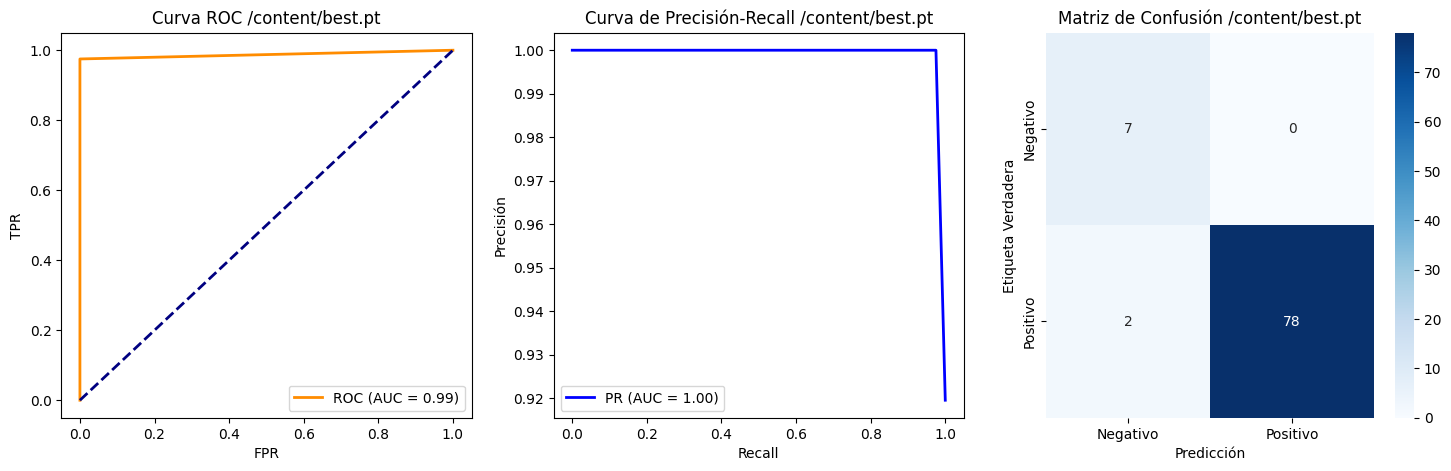

In [7]:
# Cargar el modelo YOLO   soportados:  yolov5nu.pt, yolov10n.pt, yolo11n.pt, yolov8s.pt, yolov8n.pt,  etc cualquiera soportado por ultralytics
#modelo = 'rtdetr-l.pt'
modelo = '/content/best.pt'
#model = RTDETR(modelo)
model = YOLO(modelo)

def detect_vehicles(image_path):
    try:
        results = model.predict(source=image_path, conf=conf, verbose=False)  # Ejecutar inferencia
        confidences = []
        for r in results:
            for box in r.boxes:
                clase = r.names[int(box.cls)]
                #print(clase)
                if clase.lower() == 'car' or clase.lower() == 'carro':
                    confidences.append(float(box.conf))  # Obtener la confianza
        return confidences
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")
        return []

# Ruta del archivo de anotaciones
file_path = f'{path}/test/_annotations.txt'

def procesar_anotaciones(file_path, umbral_min_conf=0.0):
    y_true = []
    y_scores = []

    with open(file_path, 'r') as file:
        for line in file:
            # Obtener datos de la línea
            partes = line.strip().split()
            imagen = partes[0]
            imagen_path = f'{path}/test/' + imagen
            numero_de_carros_reales = len(partes[1:])
            carros_confidencias = detect_vehicles(imagen_path)
            numero_de_carros_detectados = len(carros_confidencias)
            predicciones3.append(numero_de_carros_detectados)

            '''print(f"Imagen: {imagen}")
            print(f"Número de carros reales: {numero_de_carros_reales}")
            print(f"Número de carros detectados: {numero_de_carros_detectados}")


            img = mpimg.imread(imagen_path)
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes para una mejor visualización
            plt.show() '''

            # Clasificación de casos específicos
            for conf in carros_confidencias:
                y_true.append(1 if numero_de_carros_reales > 0 else 0)  # Etiqueta real
                print(f'')
                y_scores.append(conf)  # Confianza de la predicción

            # Agregar falsos negativos y falsos positivos
            if numero_de_carros_reales > numero_de_carros_detectados:
                y_true.extend([1] * (numero_de_carros_reales - numero_de_carros_detectados))  # Falsos negativos
                y_scores.extend([0.0] * (numero_de_carros_reales - numero_de_carros_detectados))

            elif numero_de_carros_detectados > numero_de_carros_reales:
                y_true.extend([0] * (numero_de_carros_detectados - numero_de_carros_reales))  # Falsos positivos
                y_scores.extend([0.0] * (numero_de_carros_detectados - numero_de_carros_reales))

    # Calcular métricas nuevamente
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Calcular la Matriz de Confusión
    umbral = 0.5
    y_pred = (np.array(y_scores) >= umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEstadísticas en el conjunto completo de datos para el modelo {modelo}:")
    print(f"AUC ROC: {roc_auc:.4f}")
    print(f"AUC Precisión-Recall: {pr_auc:.4f}")

    # Métricas adicionales
    precision_val = precision.mean() if len(precision) > 0 else 0
    recall_val = recall.mean() if len(recall) > 0 else 0
    print(f"\nPrecisión promedio: {precision_val:.4f}")
    print(f"Recall promedio: {recall_val:.4f}")
    f1=2 * (precision_val * recall_val) / (precision_val + recall_val)
    print(f"F1 promedio: {f1:.4f}")

    #Guarda resultados para comparar
    modelos.append(modelo)
    AUC_ROC.append(precision_val)
    AUC_Precisión_Recall.append(recall_val)
    f1_score.append(f1)

    print(cm)

    plt.figure(figsize=(18, 5))

    # Curva ROC
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC {modelo}')
    plt.legend(loc="lower right")

    # Curva de Precisión-Recall
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title(f'Curva de Precisión-Recall {modelo}')
    plt.legend(loc="lower left")

    # Matriz de Confusión
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión {modelo}')

    plt.show()




# Ejecución
procesar_anotaciones(file_path)

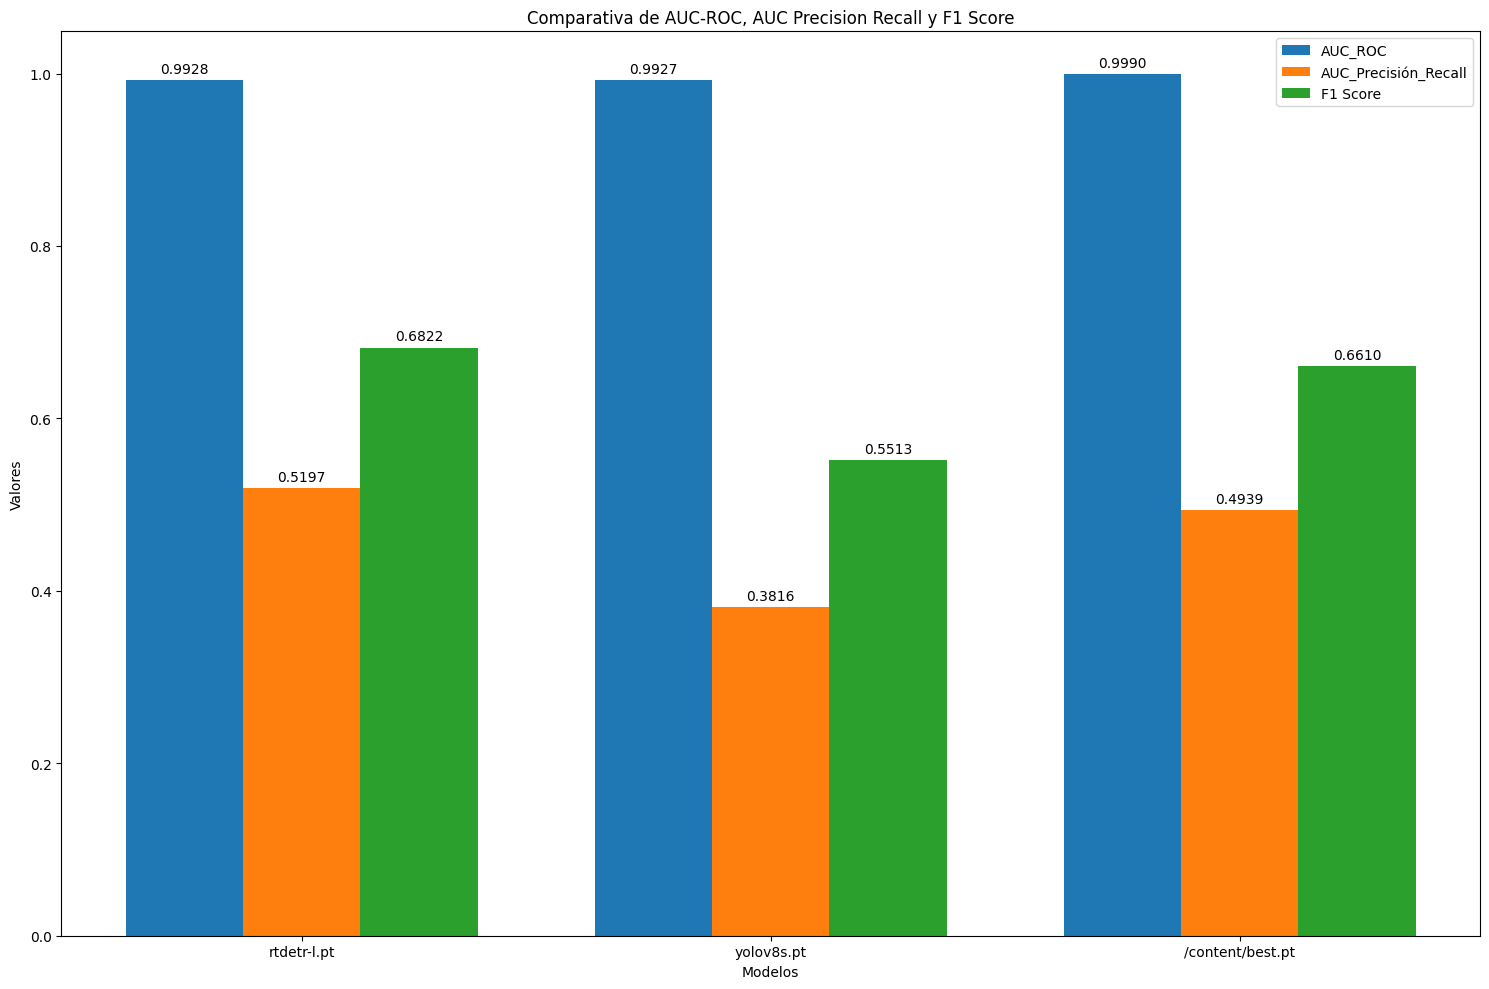

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Datos de desempeño, incluyendo el F1 Score
datos = {
    'Modelo': modelos,
    'AUC_ROC': AUC_ROC,
    'AUC_Precisión_Recall': AUC_Precisión_Recall,
    'F1_Score': f1_score
}

# Crear DataFrame
df = pd.DataFrame(datos)

# Configuración de la gráfica
fig, ax = plt.subplots(figsize=(15, 10))

# Posición de las barras
bar_width = 0.25  # Ajustar para que las barras no se superpongan
index = np.arange(len(df['Modelo']))

# Crear barras para AUC_ROC, AUC_Precisión_Recall y F1_Score
bar1 = ax.bar(index, df['AUC_ROC'], bar_width, label='AUC_ROC')
bar2 = ax.bar(index + bar_width, df['AUC_Precisión_Recall'], bar_width, label='AUC_Precisión_Recall')
bar3 = ax.bar(index + 2 * bar_width, df['F1_Score'], bar_width, label='F1 Score')

# Etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Valores')
ax.set_title('Comparativa de AUC-ROC, AUC Precision Recall y F1 Score')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df['Modelo'])
ax.legend()

# Añadir etiquetas de valor encima de las barras
def agregar_etiquetas(barras):
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(f'{altura:.4f}',
                    xy=(barra.get_x() + barra.get_width() / 2, altura),
                    xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

agregar_etiquetas(bar1)
agregar_etiquetas(bar2)
agregar_etiquetas(bar3)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# Mostrar la gráfica
plt.tight_layout()
plt.show()
